# 1. Importação de Bibliotecas e Configuração
Começamos por importar as bibliotecas necessárias e configurar o ambiente.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Bibliotecas de Scikit-Learn
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Algoritmos
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor # Certifique-se que tem o xgboost instalado (pip install xgboost)

# Configuração de estilo
sns.set(style="whitegrid")

# Semente para reprodutibilidade
SEED = 42
np.random.seed(SEED)

# 2. Leitura e Análise Exploratória de Dados (EDA)
Carregamento dos dados e análise inicial. Note que assumi a pasta dados/ conforme o seu pedido.

Dimensões de Treino: (188533, 12)
Dimensões de Teste: (125690, 11)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB
None

Valores nulos por coluna:
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident   

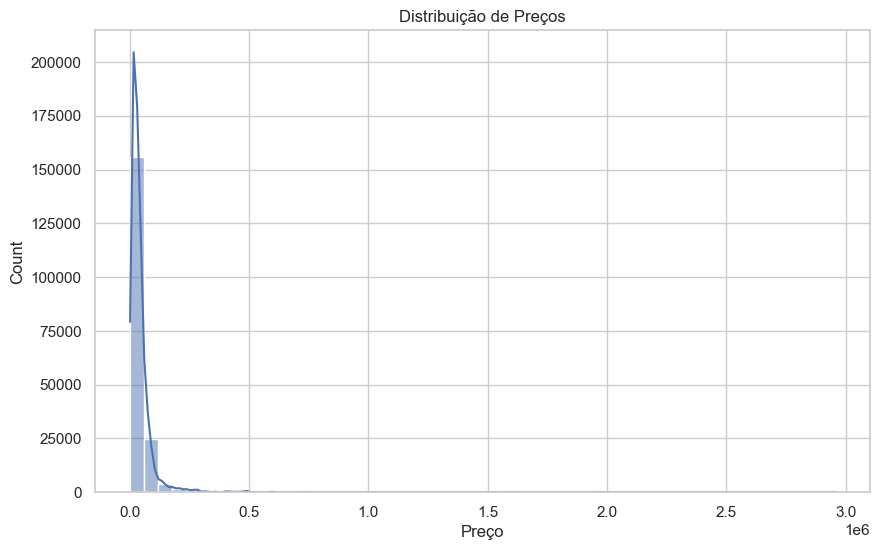

In [10]:
# Carregar os datasets
# O argumento 'index_col' define a coluna 'id' como índice para não interferir no treino
train_df = pd.read_csv('dados/train.csv', index_col='id')
test_df = pd.read_csv('dados/test.csv', index_col='id')

print(f"Dimensões de Treino: {train_df.shape}")
print(f"Dimensões de Teste: {test_df.shape}")

# Visualizar as primeiras linhas
display(train_df.head())

# Verificar tipos de dados e valores em falta
print(train_df.info())
print("\nValores nulos por coluna:")
print(train_df.isnull().sum())

# Análise da variável alvo (Price)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['price'], kde=True, bins=50)
plt.title('Distribuição de Preços')
plt.xlabel('Preço')
plt.show()

# 3. Engenharia de Atributos e Pré-processamento
Esta é a parte mais importante. Extraímos a potência (HP) e litros do motor, calculamos a idade do carro e tratamos variáveis categóricas.

In [11]:
def feature_engineering(df):
    df_eng = df.copy()
    
    # 1. Extrair informação da coluna 'engine' (HP e Litros)
    # Exemplo: "240.0HP 2.0L 4 Cylinder..."
    df_eng['hp'] = df_eng['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
    df_eng['liters'] = df_eng['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
    
    # 2. Calcular a idade do carro (assumindo ano atual como 2024 ou 2025)
    df_eng['car_age'] = 2024 - df_eng['model_year']
    
    # 3. Tratar 'clean_title' (Assumir que NaN significa 'No')
    # Mapear para binário: Yes=1, No=0 (ou manter string para o encoder)
    df_eng['clean_title'] = df_eng['clean_title'].fillna('No')
    
    # 4. Tratar 'accident'
    # Simplificar para binário: 0 se "None reported", 1 caso contrário
    df_eng['accident_binary'] = df_eng['accident'].apply(lambda x: 0 if 'None' in str(x) else 1)
    
    return df_eng

# Aplicar a engenharia de atributos
X_train_full = feature_engineering(train_df)
X_test_full = feature_engineering(test_df)

# Definir Features Numéricas e Categóricas para o Pipeline
# Removemos 'price' das features, claro
features_num = ['milage', 'model_year', 'car_age', 'hp', 'liters', 'accident_binary']
features_cat = ['brand', 'fuel_type', 'transmission', 'clean_title'] # 'model' tem muitas categorias, cuidado

# Separar Target
y = X_train_full['price']
X = X_train_full[features_num + features_cat]
X_test = X_test_full[features_num + features_cat]

print("Features selecionadas:", X.columns.tolist())

Features selecionadas: ['milage', 'model_year', 'car_age', 'hp', 'liters', 'accident_binary', 'brand', 'fuel_type', 'transmission', 'clean_title']


# 4. Construção do Pipeline de Processamento
Configuramos um ColumnTransformer para imputar dados em falta e codificar variáveis.

In [12]:
# Pipeline para dados numéricos: Imputar pela mediana + Standardizar
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para dados categóricos: Imputar 'missing' + OneHotEncoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinar ambos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_num),
        ('cat', categorical_transformer, features_cat)
    ])

# 5. Treino e Avaliação de Modelos
Aqui cumprimos o requisito de testar múltiplos algoritmos e usar Cross-Validation.

A avaliar modelos com Cross-Validation (RMSE)...
Linear Regression: RMSE Médio = 73821.49 (+/- 3591.20)
XGBoost: RMSE Médio = 74820.97 (+/- 3615.25)


C:\Users\admin\AppData\Local\Temp\ipykernel_23092\2005822736.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys())


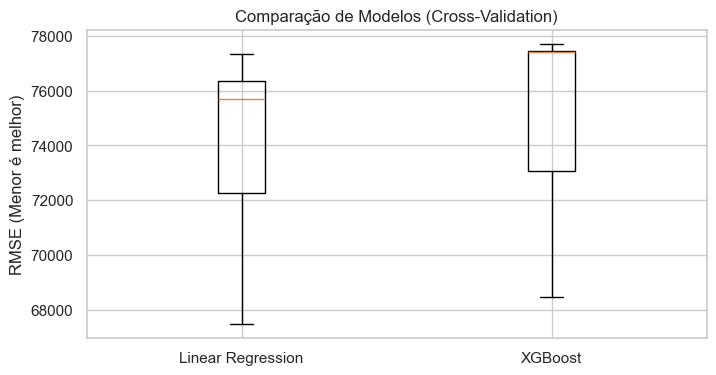

In [13]:
# Definir modelos a testar
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(random_state=SEED, objective='reg:squarederror')
}

results = {}

print("A avaliar modelos com Cross-Validation (RMSE)...")
for name, model in models.items():
    # Criar pipeline completo
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    
    # Cross Validation com 5 folds
    # Usamos 'neg_root_mean_squared_error' porque o sklearn maximiza scores (maior é melhor), 
    # por isso o erro vem negativo. Multiplicamos por -1 para ler o RMSE.
    cv_scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores = -cv_scores
    
    results[name] = rmse_scores
    print(f"{name}: RMSE Médio = {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})")

# Visualizar comparação
plt.figure(figsize=(8, 4))
plt.boxplot(results.values(), labels=results.keys())
plt.ylabel('RMSE (Menor é melhor)')
plt.title('Comparação de Modelos (Cross-Validation)')
plt.show()

# 6. Otimização de Hiperparâmetros (Grid Search)
Escolhemos o melhor modelo (provavelmente XGBoost) e ajustamos os parâmetros.

In [14]:
# Setup do Grid Search para XGBoost
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', XGBRegressor(random_state=SEED, objective='reg:squarederror'))])

# Grelha de parâmetros para testar
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0]
}

print("A iniciar Grid Search para XGBoost...")
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

print("\nMelhores Parâmetros:", grid_search.best_params_)
print(f"Melhor RMSE (CV): {-grid_search.best_score_:.2f}")

best_model = grid_search.best_estimator_

A iniciar Grid Search para XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 300, 'model__subsample': 1.0}
Melhor RMSE (CV): 72882.63


# 7. Análise de Resultados e Feature Importance
Gráficos para enriquecer o notebook.

C:\Users\admin\AppData\Local\Temp\ipykernel_23092\1621913036.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')


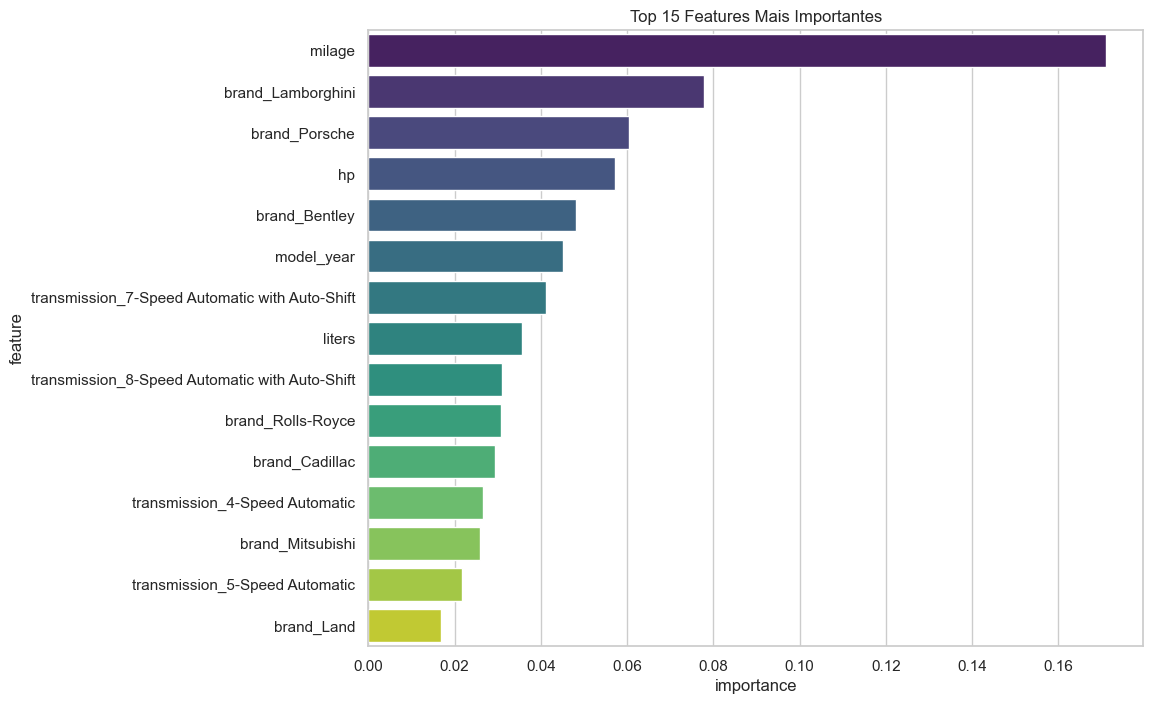

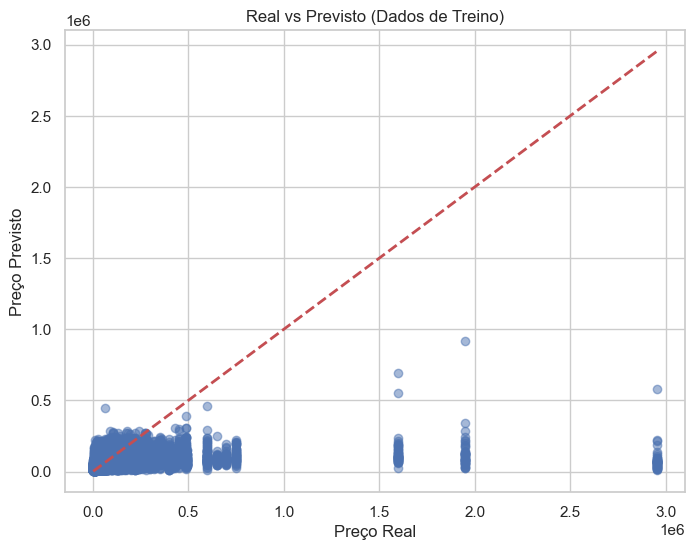

In [15]:
# Feature Importance (extraída do XGBoost dentro do Pipeline)
# Nota: Recuperar nomes das features após OneHotEncoding é um pouco técnico
try:
    # Acesso aos nomes das features categóricas transformadas
    cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']['onehot']
    cat_feature_names = cat_encoder.get_feature_names_out(features_cat)
    all_feature_names = features_num + list(cat_feature_names)
    
    # Importâncias do modelo
    importances = best_model.named_steps['model'].feature_importances_
    
    # Criar DataFrame para plotar
    feat_imp = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False).head(15) # Top 15
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')
    plt.title('Top 15 Features Mais Importantes')
    plt.show()
except Exception as e:
    print("Não foi possível gerar o gráfico de importâncias:", e)

# Gráfico de Previsão vs Real (Treino) para ver ajuste
y_pred_train = best_model.predict(X)
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_train, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Preço Real')
plt.ylabel('Preço Previsto')
plt.title('Real vs Previsto (Dados de Treino)')
plt.show()

# 8. Submissão para o Kaggle
Geração do ficheiro final.

In [16]:
# Prever nos dados de teste
test_preds = best_model.predict(X_test)

# Criar DataFrame de submissão
submission = pd.DataFrame({
    'id': test_df.index,
    'price': test_preds
})

# Verificar formato
display(submission.head())

# Guardar ficheiro csv
submission.to_csv('submission.csv', index=False)
print("Ficheiro 'submission.csv' guardado com sucesso!")

,id,price
0,188533,17324.535156
1,188534,77901.843750
2,188535,58295.589844
3,188536,30860.617188
4,188537,28670.808594


Ficheiro 'submission.csv' guardado com sucesso!
